# Household Power Consumption

## Disclaimer

AI (ChatGPT) was user to help write this project, for both code and documentation. Any code generated has been studied, and any documentation has been verified.

### Dataset Download and Setup

Please download the dataset from [here](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption) and extract the .txt file into the `electricity_usage` folder (where `main.ipynb` is located).

### About the Dataset

This dataset has taken "measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years."

The original format is in a `.txt` file, but should be easy enough to convert to something more workable like a `.csv` file.

The current headings are as follows:
1. date: Date in format dd/mm/yyyy
2. time: time in format hh:mm:ss
3. global_active_power: household global minute-averaged active power (in kilowatt)
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

I am not entirely sure what the difference between **active** and **reactive** power is, and I cannot seem to find any documentation about it from the dataset source.

It could be assumed that the true total electricity usage is as follows: 
> `total_consumption = global_active_power + sub_metering_1 + sub_metering_2 + sub_metering_3`

### What can we do with this data?

Looking at the dataset, we could make predictions about whether or not we can expect higher power consumpution at a certain date and time. For example, you would probably use more power at 5PM in January vs. 6AM in August. We could make a simple decision tree model to make these predictions.

In [1]:
import pandas as pd
import numpy as np

""" 

Here I am trying to load the data from the file 'household_power_consumption.txt' into a pandas dataframe.
Since it is a .txt file, I am using the read_csv method of pandas to read the file and specifying the separator as ';'. I also specify the na_values as ['?', ''] to replace the missing values with NaN.

"""

try:
    df = pd.read_csv('household_power_consumption.txt', sep=';', na_values=['?', ''])
    print("Successfully loaded the data into a pandas dataframe!")
except FileNotFoundError:
    print('File not found')
    exit()

Successfully loaded the data into a pandas dataframe!


That seems to have worked, now I want to convert all of the column headers to lowercase. 

Next Steps:
1. I want to convert the date and time columns into a datetime object and drop the original date and time columns.
2. Using this new datetime object, create the new `year`, `month`, `day`, `hour`, `day_of_week` and `quarter` features.
3. Create the `total_consumption` feature. 

In [2]:
# Convert all column headers to lowercase
df.columns = [col.lower() for col in df.columns]

# Convert date and time columns
df['date_time'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Drop the original date and time columns
df = df.drop(['date', 'time'], axis=1)

# Handle missing values
df = df.replace({np.nan: 0})

# Creating new features from datetime object
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek  # Monday=0, Sunday=6
df['quarter'] = df['date_time'].dt.quarter

# Calculate total consumption
df['total_consumption'] = df['global_active_power'] + df['sub_metering_1'] + df['sub_metering_2'] + df['sub_metering_3']

df.columns

Index(['global_active_power', 'global_reactive_power', 'voltage',
       'global_intensity', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3', 'date_time', 'year', 'month', 'day', 'hour',
       'day_of_week', 'quarter', 'total_consumption'],
      dtype='object')

The next step is to create the consumption categories of low, medium and high.

In [3]:
consumption_stats = df['total_consumption'].describe()
low_threshold = consumption_stats['25%']
high_threshold = consumption_stats['75%']

def categorize_consumption(consumption):
    if consumption < low_threshold:
        return 'low'
    elif consumption < high_threshold:
        return 'medium'
    else:
        return 'high'

df['consumption_category'] = df['total_consumption'].apply(categorize_consumption)

consumption_counts = df['consumption_category'].value_counts()
print(df.head())
print(consumption_counts)

   global_active_power  global_reactive_power  voltage  global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   sub_metering_1  sub_metering_2  sub_metering_3           date_time  year  \
0             0.0             1.0            17.0 2006-12-16 17:24:00  2006   
1             0.0             1.0            16.0 2006-12-16 17:25:00  2006   
2             0.0             2.0            17.0 2006-12-16 17:26:00  2006   
3             0.0             1.0            17.0 2006-12-16 17:27:00  2006   
4             0.0             1.0            17.0 2006-12-16 17:28:00  2006   

   month  day  hour  day_of_week  quarter  total_consumption  \
0   

## Data Preprocessing

- Converted datetime features to numerical (year, month, day)
- Dropped original datetime columns
- Converted all features to float type

## Feature Engineering

- Removed 'consumption_category' and 'total_consumption' from features
- Used vectorized operations for datetime processing

## Model Configuration

Reduced complexity with:
1. Added class balancing with class_weight='balanced'
2. Enabled parallel processing with n_jobs=-1

## Final Results

- Achieved 0.87 precision and 0.99 recall for 'high' class.
- Achieved 0.99 precision and 1.00 recall for 'low' class.
- Achieved 1.00 precision and 0.92 recall for 'medium' class.

Attempts were made to lower some precision for 'medium', and lower precision and recall for 'low' but unfortunately I was not able to find a method to do so within the time frame I had. One observation I did notice however is that the number of 'medium' instances is roughly 2x the number of high and low classes. Below is the classification report and the confusion matrix.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Check data types
print("Data types before conversion:")
print(df.dtypes)

# Vectorized datetime conversion
datetime_columns = df.select_dtypes(include=['datetime64']).columns
for col in datetime_columns:
    # Create all date features at once using vectorized operations
    # Vectorized operations are preferred here because they are more efficient and faster than applying functions row by row.
    # This is especially important when dealing with large datasets, as it significantly reduces the computation time.
    # See more here: https://pythonspeed.com/articles/pandas-vectorization/
    df = df.assign(**{
        f'{col}_year': df[col].dt.year,
        f'{col}_month': df[col].dt.month,
        f'{col}_day': df[col].dt.day
    })

# Drop original datetime columns all at once
df = df.drop(columns=datetime_columns)

# Prepare features (X) and target (y)
X = df.drop(['consumption_category', 'total_consumption'], axis=1)  # All columns except target (consumption_category)
y = df['consumption_category'] # Target column

# Convert all features to float
X = X.astype(float)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model with anti-overfitting parameters
rf_model = RandomForestClassifier(
    n_estimators=50,  # Reduced number of trees
    max_depth=5,      # Reduced depth
    min_samples_split=20,  # Increased min samples to split
    min_samples_leaf=10,   # Increased min samples per leaf
    max_features='sqrt',   # Restrict features per split
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Train model
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 Important Features:")
print(feature_importance.head(10))

Data types before conversion:
global_active_power             float64
global_reactive_power           float64
voltage                         float64
global_intensity                float64
sub_metering_1                  float64
sub_metering_2                  float64
sub_metering_3                  float64
date_time                datetime64[ns]
year                              int32
month                             int32
day                               int32
hour                              int32
day_of_week                       int32
quarter                           int32
total_consumption               float64
consumption_category             object
dtype: object

Classification Report:
              precision    recall  f1-score   support

        high       0.87      0.99      0.92    104163
         low       0.99      1.00      0.99    103561
      medium       1.00      0.92      0.95    207328

    accuracy                           0.96    415052
   macro avg       0

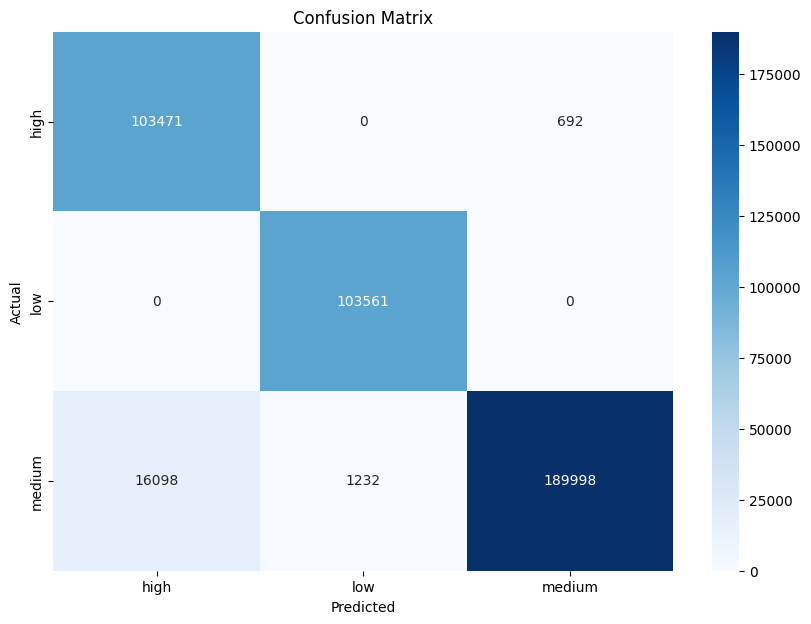

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Pretty print with seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Make predictions
sample_data = pd.Series({
    'global_active_power': 1.0,
    'global_reactive_power': 0.0,
    'voltage': 240.0,
    'global_intensity': 4.0,
    'sub_metering_1': 0.0,
    'sub_metering_2': 1.0,
    'sub_metering_3': 1.0,
    'year': 2006,
    'month': 12,
    'day': 16,
    'hour': 17,
    'day_of_week': 5,
    'quarter': 4
})

# Convert to 2d array
sample_data = sample_data.values.reshape(1, -1)

# Predict
predictions = rf_model.predict(sample_data)
print("\nPredictions:")
print(predictions)

/home/jack/College/DataSciML/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.